In [351]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

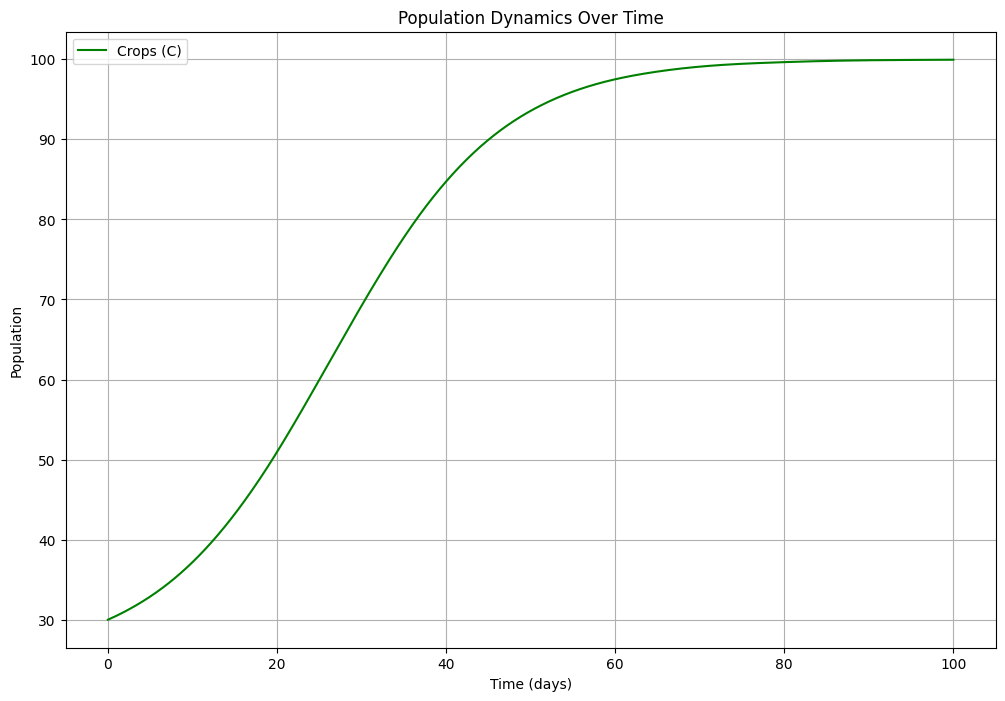

In [352]:
r_C = 0.1  # 作物生长速率
K_C = 75  # 作物最大容量

# 无影响下的作物生长曲线
def crop_growth_ode(t, y):
    C = y
    dCdt = r_C * (C-25) * (1 - (C-25) / K_C)
    
    return [dCdt]
    
# 初始条件
y0 = [30]  # 初始作物、杂草、害虫、鸟类数量

# 时间范围
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 求解ODE
solution = solve_ivp(crop_growth_ode, t_span, y0, t_eval=t_eval, method='RK45')

# 提取结果
t = solution.t
C = solution.y[0]  # Flatten the array

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()

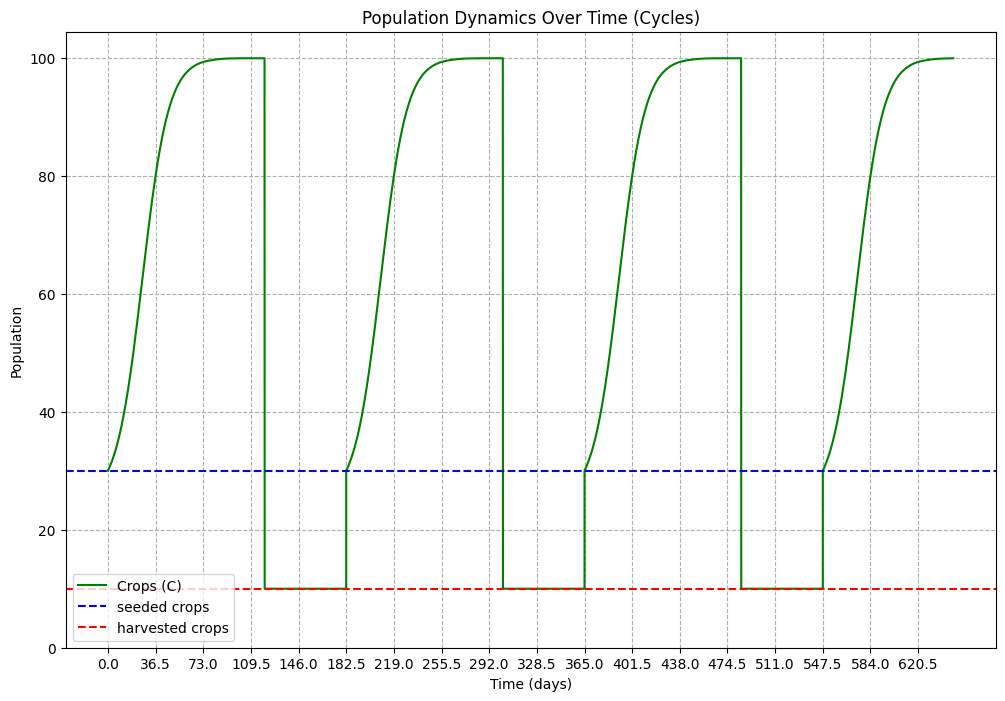

In [353]:
# 定义参数
mature_period = 20  # 成熟期时长
planting_interval = 82.5  # 种植间期时长

# 初始化总时间和总结果
t_total = t
C_total = C

# 循环
for i in range(3):
    # 延续曲线
    t_additional = np.linspace(t_total[-1], t_total[-1] + planting_interval, 680)
    C_additional = np.piecewise(t_additional, 
                                [t_additional <= t_total[-1] + mature_period, 
                                 (t_additional > t_total[-1] + mature_period) & (t_additional <= t_total[-1] + planting_interval)], 
                                [C_total[-1], 10])

    # 重新初始化
    t_new_cycle = np.linspace(t_total[-1] + planting_interval, t_total[-1] + planting_interval + 100, 1000)
    solution_new_cycle = solve_ivp(crop_growth_ode, (t_total[-1] + planting_interval, t_total[-1] + planting_interval + 100), [30], t_eval=t_new_cycle, method='RK45')
    C_new_cycle = solution_new_cycle.y[0]

    # 合并时间和结果
    t_total = np.concatenate((t_total, t_additional, t_new_cycle))
    C_total = np.concatenate((C_total, C_additional, C_new_cycle))

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t_total, C_total, label='Crops (C)', color='green')
plt.axhline(y=30, color='blue', linestyle='--', label='seeded crops')
plt.axhline(y=10, color='red', linestyle='--', label='harvested crops')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time (Cycles)')
plt.legend()
plt.grid(True, linestyle='--')
plt.xticks(np.arange(0, max(t_total)+1, 36.5))
plt.yticks(np.arange(0, max(C_total)+1, 20))
plt.show()

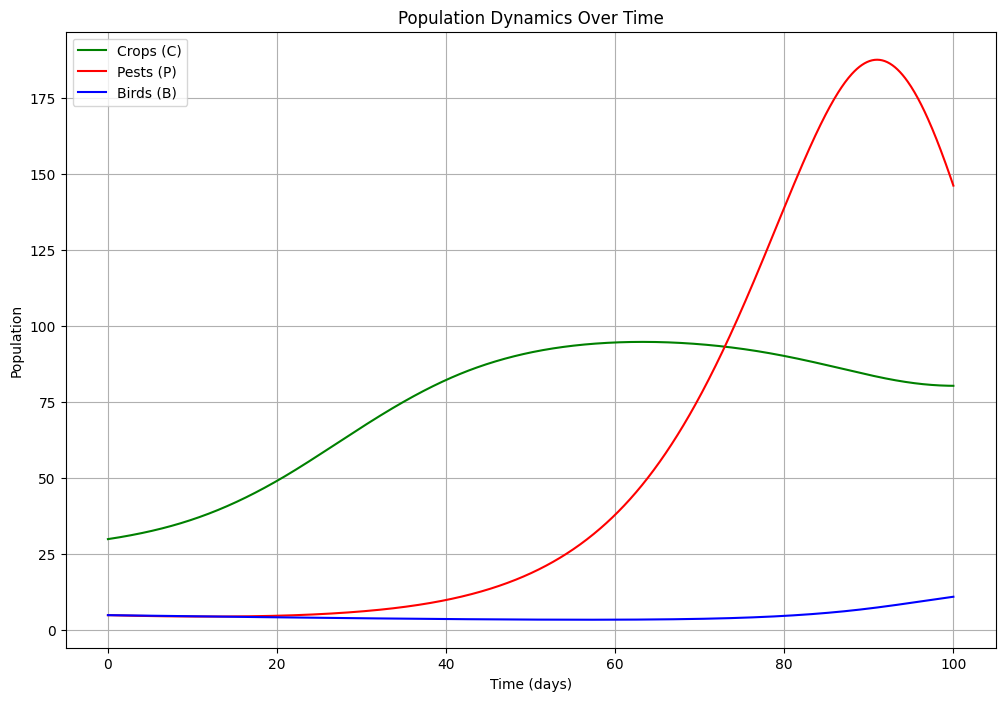

In [354]:
# 考虑虫害与鸟类
r_P = 0.03  # 害虫增长速率
K_P = 10000  # 害虫最大容量（很大）
r_B = 0.001  # 鸟类增长速率(很小)
K_B = 50  # 鸟类最大容量

beta_PC = 0.001  # 作物-害虫交互系数
beta_BP = 0.0003  # 鸟类-害虫交互系数
gamma_CP = 0.01  # 作物-害虫交互系数(-)
gamma_PB = 0.015  # 害虫-鸟类交互系数（-）
nu_B = 0.01  # 鸟类死亡率

def odes(t, y):
    C, P, B = y
    dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [30, 5, 5]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t = solution.t
C, P, B = solution.y

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()


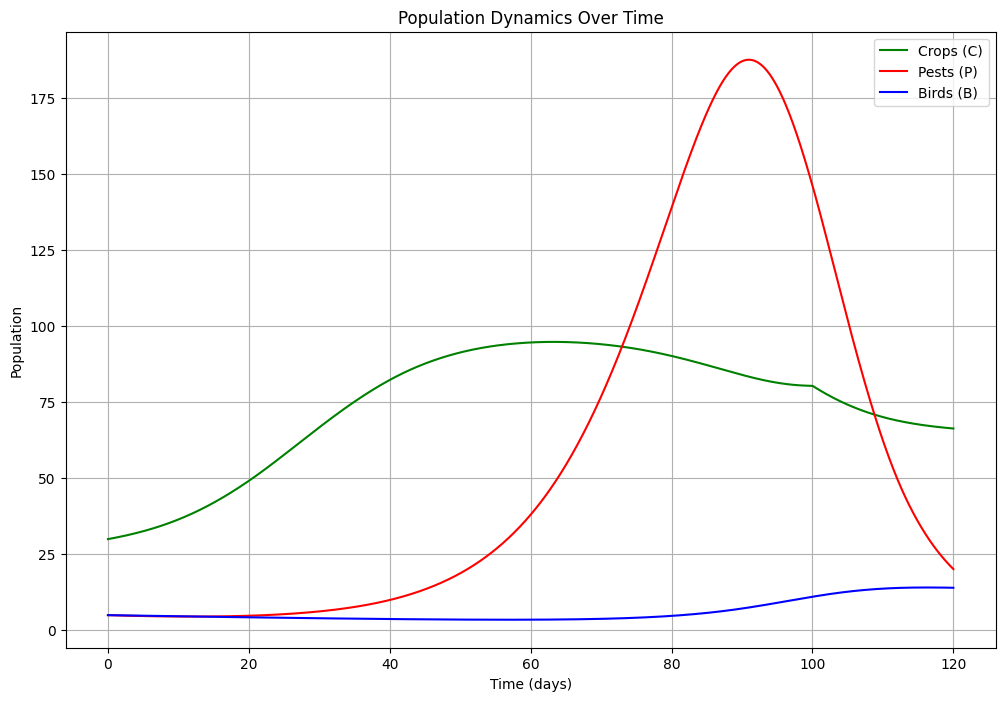

In [355]:
# 100~120天内，作物停止生长，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (100, 120)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()



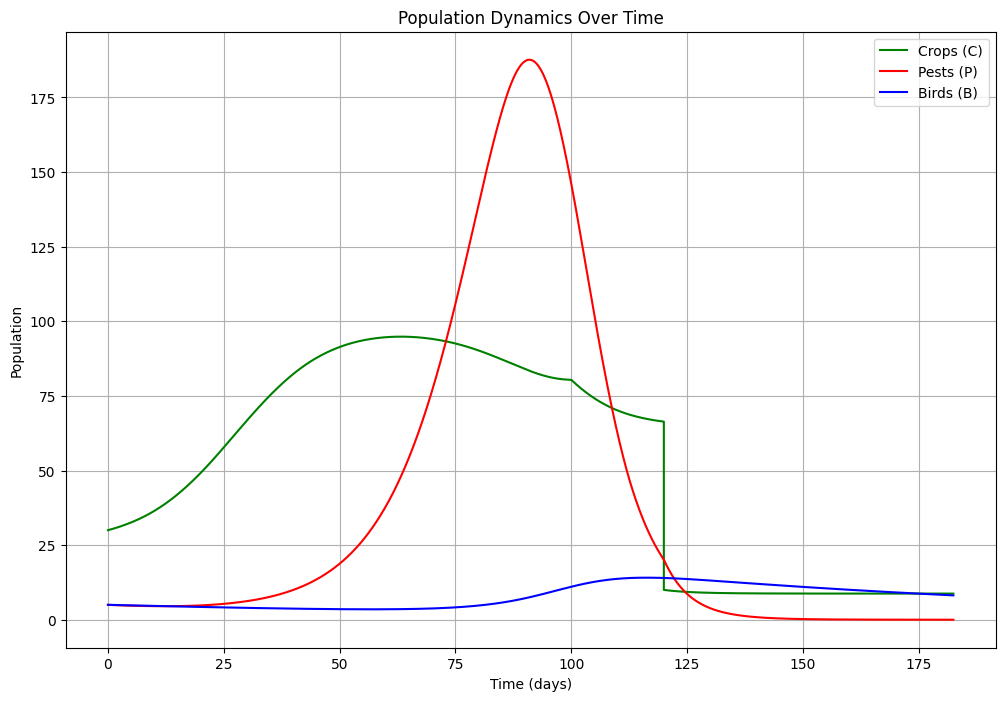

In [356]:
# 120~182.5天内，作物初始条件改为10，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP*P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [10, P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (120, 182.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()

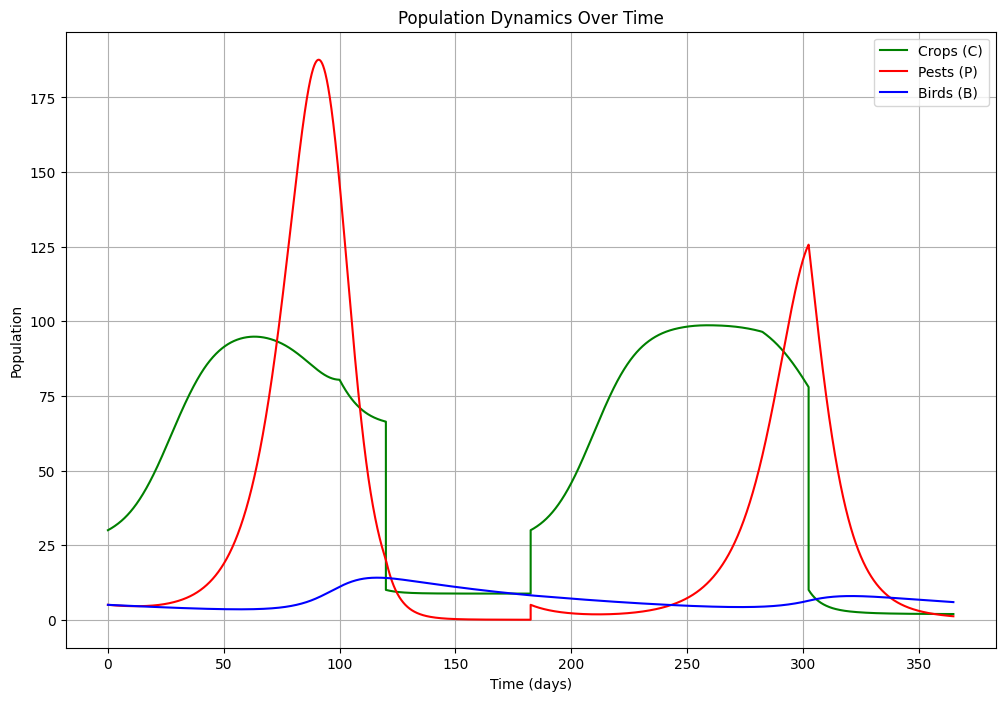

In [357]:
# 182.5~282.5天内，作物初始条件改为30，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [30, 5, B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (182.5, 282.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 282.5~302.5天内，作物停止生长，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (282.5, 302.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 120~182.5天内，作物初始条件改为10，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP*P*C*0.1
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [10, P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (302.5, 365)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))



# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()


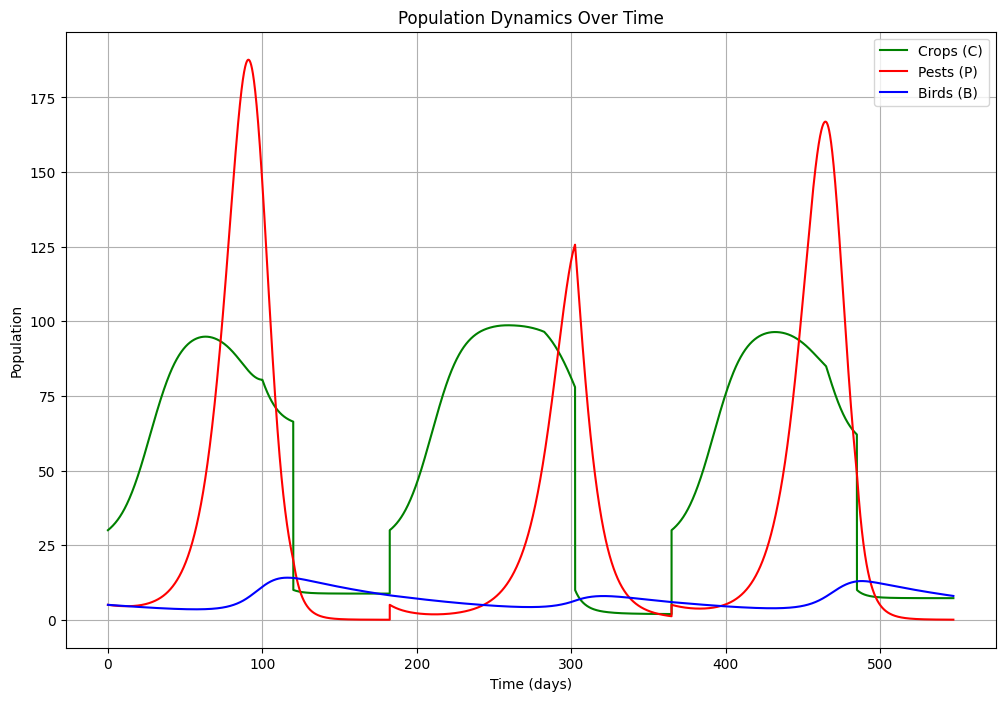

In [358]:
T = 365

# ==============================
# 作物初始条件改为30，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [30, 5, B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T, T+100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 作物停止生长，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T+100, T+120)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 作物初始条件改为10，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP*P*C*0.1
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [10, P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T+120, T+182.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))



# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()


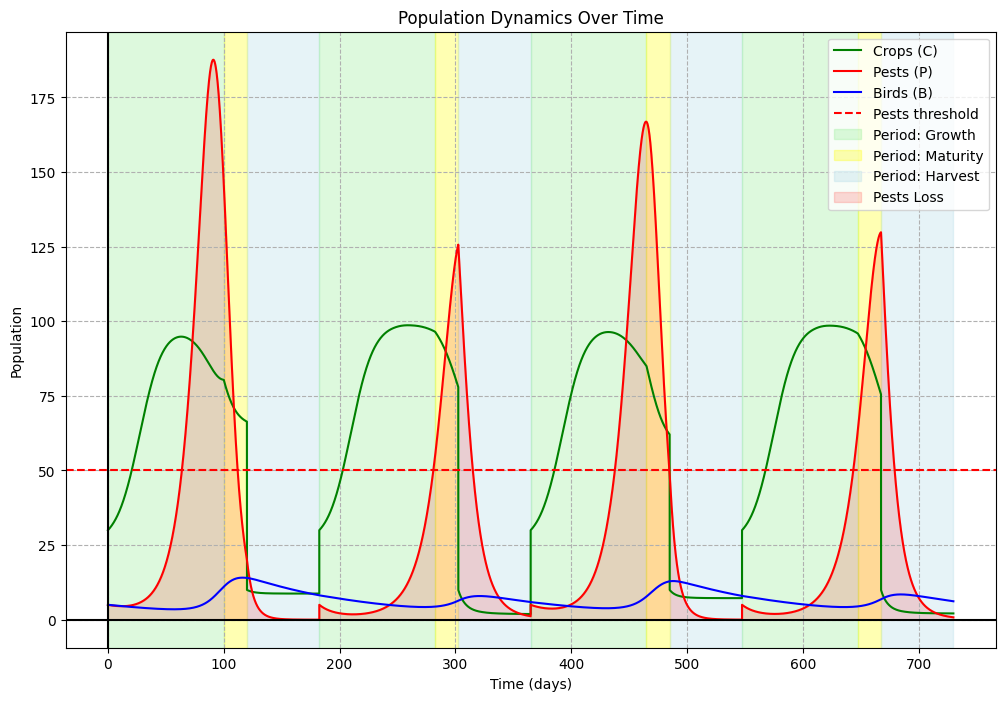

In [359]:
T = 365+182.5

# ==============================
# 作物初始条件改为30，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [30, 5, B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T, T+100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 作物停止生长，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP * P
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T+100, T+120)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# ==============================
# 作物初始条件改为10，更新odes
def odes(t, y):
    C, P, B = y
    dCdt = -gamma_CP*P*C*0.1
    dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B    
    return [dCdt, dPdt, dBdt]

# 初始条件
y0 = [10, P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

# 时间范围
t_span = (T+120, T+182.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 提取结果
solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
t2 = solution.t
C2, P2, B2 = solution.y

C = np.concatenate((C, C2))
P = np.concatenate((P, P2))
B = np.concatenate((B, B2))
t = np.concatenate((t, t2))

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.axhline(y=50, color='red', linestyle='--', label='Pests threshold')

T = 0
# 添加不同时期的背景颜色
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3, label='Period: Growth')
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3, label='Period: Maturity')
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3, label='Period: Harvest')
T = 365/2
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)
T = 365
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)
T = 365+182.5
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)

# 将P线与x轴之间的面积填涂为红色
plt.fill_between(t, P, where=(P > 0), color='red', alpha=0.15, interpolate=True, label='Pests Loss')
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)


plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend()
plt.grid(True, linestyle='--')  # 修改背景格线为虚线
plt.show()

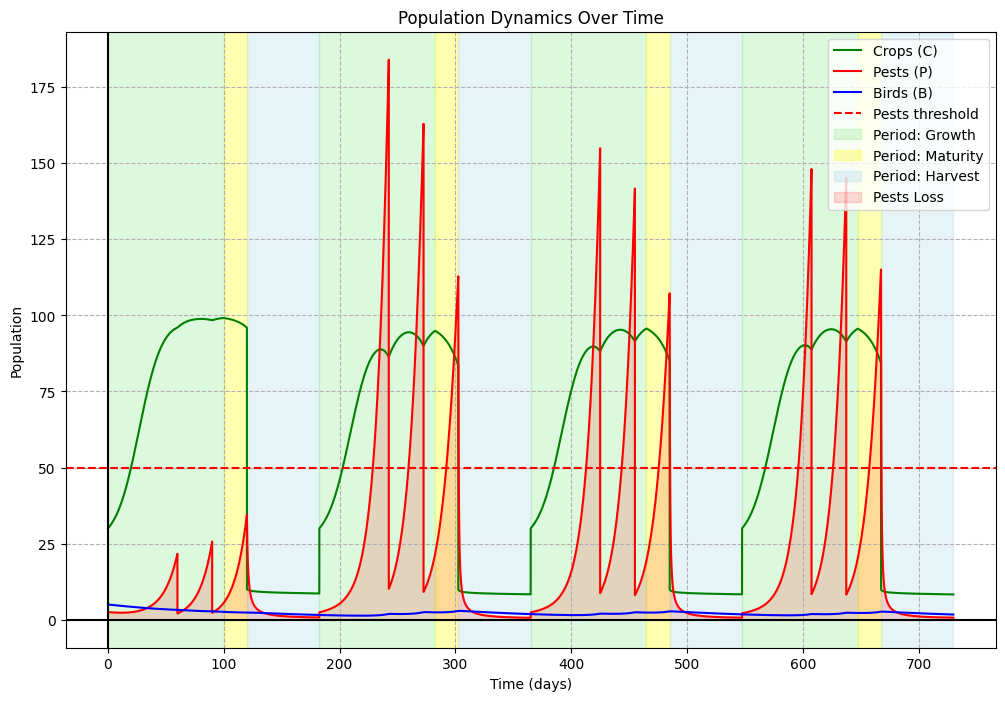

In [360]:
# 考虑引入杀虫剂的作用
import random

# 重置
T_array = [0, 365/2, 365, 365+182.5]
C = np.array([])
P = np.array([])
B = np.array([])
t = np.array([])

bird_const = 0.005
eliconst = 0.05

for i in range(4):
    T = T_array[i]
    # ==============================
    # 作物初始条件改为30，更新odes
    def odes(t, y):
        C, P, B = y
        dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
        dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
        dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B  +bird_const/B   
        return [dCdt, dPdt, dBdt]


    # 如果B不为空，则设置初始条件，否则设为[30,5,5]
    if len(B)>0:
        # y0 = [30, np.random.randint(2,5), B[-1]]  # 初始作物、害虫、鸟类数量
        y0 = [30, 2+random.random(), B[-1]]  # 初始作物、害虫、鸟类数量
    else :
        y0 = [30, 2+random.random(),5]

    # 时间范围
    t_span = (T, T+60)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # 提取结果
    solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    t2 = solution.t
    C2, P2, B2 = solution.y

    C = np.concatenate((C, C2))
    P = np.concatenate((P, P2))
    B = np.concatenate((B, B2))
    t = np.concatenate((t, t2))
    
    
    # ==============================
    # t=40时引入杀虫剂，更新odes（的初始条件）
    def odes(t, y):
        C, P, B = y
        dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
        dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
        dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B   +bird_const/B  
        return [dCdt, dPdt, dBdt]

    y0 = [C[-1], eliconst*P[-1]+1, B[-1]]  # 初始作物、害虫、鸟类数量

    # 时间范围
    t_span = (T+60, T+90)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # 提取结果
    solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    t2 = solution.t
    C2, P2, B2 = solution.y

    C = np.concatenate((C, C2))
    P = np.concatenate((P, P2))
    B = np.concatenate((B, B2))
    t = np.concatenate((t, t2))
    
    
    # # ==============================
    # # t=60时引入杀虫剂，更新odes（的初始条件）
    # def odes(t, y):
    #     C, P, B = y
    #     dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    #     dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    #     dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B + bird_const/B  
    #     return [dCdt, dPdt, dBdt]

    # y0 = [C[-1], eliconst*P[-1]+1, B[-1]]  # 初始作物、害虫、鸟类数量

    # # 时间范围
    # t_span = (T+40, T+60)
    # t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # # 提取结果
    # solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    # t2 = solution.t
    # C2, P2, B2 = solution.y

    # C = np.concatenate((C, C2))
    # P = np.concatenate((P, P2))
    # B = np.concatenate((B, B2))
    # t = np.concatenate((t, t2))
    
    # # ==============================
    # # t=80时引入杀虫剂，更新odes（的初始条件）
    # def odes(t, y):
    #     C, P, B = y
    #     dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
    #     dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
    #     dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B   +bird_const/B  
    #     return [dCdt, dPdt, dBdt]

    # y0 = [C[-1], eliconst*P[-1]+1, B[-1]]  # 初始作物、害虫、鸟类数量
    # # y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

    # # 时间范围
    # t_span = (T+60, T+80)
    # t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # # 提取结果
    # solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    # t2 = solution.t
    # C2, P2, B2 = solution.y

    # C = np.concatenate((C, C2))
    # P = np.concatenate((P, P2))
    # B = np.concatenate((B, B2))
    # t = np.concatenate((t, t2))
    
    
    
    # ==============================
    # t=80时引入杀虫剂，更新odes（的初始条件）
    def odes(t, y):
        C, P, B = y
        dCdt = r_C * (C-25) * (1 - (C-25) / K_C) - gamma_CP * P
        dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
        dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B   +bird_const/B  
        return [dCdt, dPdt, dBdt]

    y0 = [C[-1], eliconst*P[-1]+1, B[-1]]  # 初始作物、害虫、鸟类数量
    # y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

    # 时间范围
    t_span = (T+90, T+100)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # 提取结果
    solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    t2 = solution.t
    C2, P2, B2 = solution.y

    C = np.concatenate((C, C2))
    P = np.concatenate((P, P2))
    B = np.concatenate((B, B2))
    t = np.concatenate((t, t2))
    
    


    # ==============================
    # 作物停止生长，同时使用杀虫剂，更新odes
    def odes(t, y):
        C, P, B = y
        dCdt = -gamma_CP * P
        dPdt = r_P * P * (1 - P / K_P) + beta_PC*C*P - gamma_PB * B*P
        dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B  +bird_const/B   
        return [dCdt, dPdt, dBdt]

    # 初始条件
    # y0 = [C[-1], eliconst*P[-1]+1, B[-1]]  # 初始作物、害虫、鸟类数量
    y0 = [C[-1], P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

    # 时间范围
    t_span = (T+100, T+120)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # 提取结果
    solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    t2 = solution.t
    C2, P2, B2 = solution.y

    C = np.concatenate((C, C2))
    P = np.concatenate((P, P2))
    B = np.concatenate((B, B2))
    t = np.concatenate((t, t2))

    # ==============================
    # 作物初始条件改为10，更新odes
    def odes(t, y):
        C, P, B = y
        dCdt = -gamma_CP*P*C*0.1
        dPdt = r_P * P * (1 - P / 1) + beta_PC*C*P - gamma_PB * B*P
        dBdt = r_B * B * (1 - B / K_B) + beta_BP*B*P - nu_B*B + bird_const/B   
        return [dCdt, dPdt, dBdt]

    # 初始条件
    y0 = [10, P[-1], B[-1]]  # 初始作物、害虫、鸟类数量

    # 时间范围
    t_span = (T+120, T+182.5)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # 提取结果
    solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
    t2 = solution.t
    C2, P2, B2 = solution.y

    C = np.concatenate((C, C2))
    P = np.concatenate((P, P2))
    B = np.concatenate((B, B2))
    t = np.concatenate((t, t2))

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, C, label='Crops (C)', color='green')
plt.plot(t, P, label='Pests (P)', color='red')
plt.plot(t, B, label='Birds (B)', color='blue')
plt.axhline(y=50, color='red', linestyle='--', label='Pests threshold')

T = 0
# 添加不同时期的背景颜色
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3, label='Period: Growth')
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3, label='Period: Maturity')
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3, label='Period: Harvest')
T = 365/2
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)
T = 365
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)
T = 365+182.5
plt.axvspan(T, T+100, color='lightgreen', alpha=0.3)
plt.axvspan(T+100, T+120, color='yellow', alpha=0.3)
plt.axvspan(T+120, T+182.5, color='lightblue', alpha=0.3)

# 将P线与x轴之间的面积填涂为红色
plt.fill_between(t, P, where=(P > 0), color='red', alpha=0.15, interpolate=True, label='Pests Loss')
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)


plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Population Dynamics Over Time')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--')  # 修改背景格线为虚线
plt.show()